# Определение перспективного тарифа для телеком-компании

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.  
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше, а имеено проверить две гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


**Описание тарифов**  

*Тариф «Смарт»*
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей  

*Тариф «Ультра»*  
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

***Примечание***  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

***Описание данных***  
Таблица *users* (информация о пользователях):  
`user_id` — уникальный идентификатор пользователя  
`first_name` — имя пользователя  
`last_name` — фамилия пользователя  
`age` — возраст пользователя (годы)  
`reg_date` — дата подключения тарифа (день, месяц, год)  
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)   
`city` — город проживания пользователя  
`tariff` — название тарифного плана  

Таблица *calls* (информация о звонках):  
`id` — уникальный номер звонка  
`call_date` — дата звонка  
`duration` — длительность звонка в минутах  
`user_id` — идентификатор пользователя, сделавшего звонок  

Таблица *messages* (информация о сообщениях):  
`id` — уникальный номер сообщения  
`message_date` — дата сообщения  
`user_id` — идентификатор пользователя, отправившего сообщение 

Таблица *internet* (информация об интернет-сессиях): 
`id` — уникальный номер сессии  
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)  
`session_date` — дата интернет-сессии  
`user_id` — идентификатор пользователя  

Таблица *tariffs* (информация о тарифах):  
`tariff_name` — название тарифа  
`rub_monthly_fee` — ежемесячная абонентская плата в рублях  
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату  
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату  
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета  
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

## Исследование данных и их предобработка

Начнем с импорта необходимых нам библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

Импортируем все предоставленные *csv-файлы* и сохраним их в датафреймы со схожими названиями:

In [2]:
try:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')

Поскольку у нас 5 таблиц, с которыми придется работать, создадим обзорную функцию, которая будет выводить основную информацию от предоставленных данных

In [3]:
def view_func(data):
    '''
    Обзорная функция для получения первичной информации о датафрейме
    -Вывод первых пяти строк
    -Применение функции info()
    -Доля пропущенных значений по столбцам
    -Сумма явных дубликатов
    '''
    print('Внешний вид датафрейма:')
    print(data.head(5))
    print('``````````````````````````````````````````````````')
    print('Типы данных, кол-во строк и столбцов:')
    print(data.info())
    print('``````````````````````````````````````````````````')
    print('Доля пропущенных значений:')    
    print(data.isnull().mean())
    print('``````````````````````````````````````````````````')
    print('Количество явных дубликатов:')
    print(data.duplicated().sum())
    print('``````````````````````````````````````````````````')

### Предобработка таблицы calls

Посмотрим данные в таблице `cells`

In [4]:
view_func(calls)

Внешний вид датафрейма:
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
``````````````````````````````````````````````````
Доля пропущенных значений:
id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64
``````````````````````````````````````````````````
Количе

Пропусков нет, дубликатов нет, поменяем тип данных в столбце `call_date` на **datetime**:

In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Поскольку в нашем исследовании нужно будет проводить исследования по месяцам, добавим столбец `call_month` в наш датафрейм:

In [6]:
calls['call_month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,call_month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


Посмотрим расброс данных и присутствие аномалий:

In [7]:
calls.describe()

,duration,user_id,call_month
count,202607.000000,202607.000000,202607.000000
mean,6.755887,1253.940619,8.574067
std,5.843365,144.722751,2.787093
min,0.000000,1000.000000,1.000000
25%,1.300000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,10.700000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


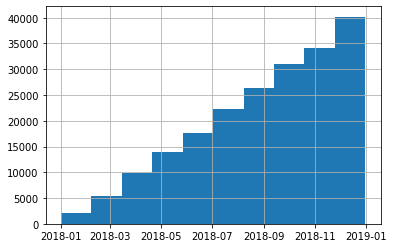

In [8]:
calls['call_date'].hist();

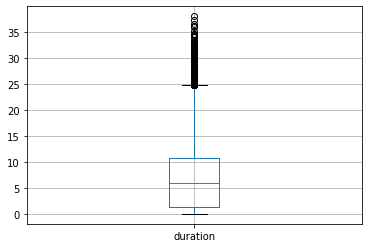

In [9]:
calls.boxplot('duration');

In [10]:
calls[calls['duration'] > 25]

,id,call_date,duration,user_id,call_month
508,1002_18,2018-07-16,26.44,1002,7
766,1003_59,2018-11-06,26.99,1003,11
1753,1005_350,2018-06-26,25.82,1005,6
1832,1005_429,2018-08-03,25.57,1005,8
1844,1005_441,2018-11-27,25.29,1005,11
...,...,...,...,...,...
199501,1491_460,2018-11-24,27.29,1491,11
199516,1491_475,2018-12-10,26.36,1491,12
200421,1494_83,2018-09-02,26.12,1494,9
201599,1496_421,2018-10-19,26.15,1496,10


В целом все не так уж и плохо, есть 678 значений длительности звонков более 25 минут, что, с одной стороны, кажется выбросами, но с другой стороны, это в полне себе возможно в реальной жизни.  
На данном этапе решаю их оставить,  если при проверке гипотез будет мешать выполнению функций - то уберу.  
Нулевые значения в `duration` тоже оставляем, потому что в инструкции написано, что это пропущенные звонки

### Предобработка таблицы internet

Проверим данные в таблице `internet`

In [11]:
view_func(internet)

Внешний вид датафрейма:
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
``````````````````````````````````````````````````
Доля пропущенных значений:
Unname

Пропусков и дубликатов нет, тоже поменяем `session_date` на **datetime** формат и удалим непонятный столбец `Unnamed: 0`, который не имеет названия и дублирует индексы датафрейма

In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet = internet.drop(columns = ['Unnamed: 0'],axis = 1)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Тоже добавим столбец `session_month` для будущего исследования:

In [13]:
internet['session_month'] = internet['session_date'].dt.month
internet

,id,mb_used,session_date,user_id,session_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


Посмотрим расброс данных и присутствие аномалий:

In [14]:
internet.describe()

,mb_used,user_id,session_month
count,149396.000000,149396.000000,149396.000000
mean,370.192426,1252.099842,8.563315
std,278.300951,144.050823,2.788717
min,0.000000,1000.000000,1.000000
25%,138.187500,1130.000000,7.000000
50%,348.015000,1251.000000,9.000000
75%,559.552500,1380.000000,11.000000
max,1724.830000,1499.000000,12.000000


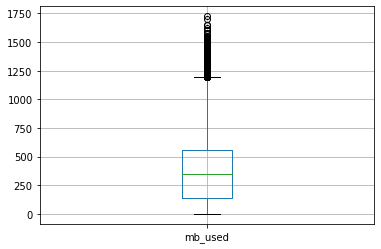

In [15]:
internet.boxplot('mb_used');

Я особых аномалий не вижу, есть юзеры, которые вообще не пользуются интернетом, есть те, у кого сессии более 1гб, что тоже вполне себе применимо в реальной жизни.

### Предобработка таблицы messages

Проверим данные в таблице `messages`

In [16]:
view_func(messages)

Внешний вид датафрейма:
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
``````````````````````````````````````````````````
Доля пропущенных значений:
id              0.0
message_date    0.0
user_id         0.0
dtype: float64
``````````````````````````````````````````````````
Количество явных дубликатов:
0
``````````````````````````````````````````````````


Также как и в предыдущих таблицах, поменяем тип данных в `message_date` на **datetime**

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Добавим столбец с номером месяца:

In [18]:
messages['message_month'] = messages['message_date'].dt.month
messages

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


### Предобработка таблицы tariffs

Посмотрим таблицу `tariffs`

In [19]:
view_func(tariffs)

Внешний вид датафрейма:
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 


Это просто описательная таблица для 2-х тарифов, менять нечего. 

### Предобработка таблицы users

Посмотрим таблицу `users`

In [20]:
view_func(users)

Внешний вид датафрейма:
   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  
``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_nam

Датафрейм по абонентам, всего 500 абонентов, для начала приведем `churn_date`и `reg_date` к **datetime** формату:

In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Есть пропуски в столбце `churn_date`, но они полезные и говорят нам о том, что абонент еще был подключен к данному тарифу

Изучим столбец `city`:

In [22]:
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

Все хорошо, неявных дубликатов не замечено. 

### Промежуточный вывод

Мы проверили все 5 представленных баз данных на правильность типов данных и привели их к нужному формату, проверили на выбросы и аномалии там, где это необходимо, проверили на дубликаты и пропущенные значения. 
Теперь все 5 датафреймов приведены к единому стилю, что позволит нам проводить наши дальнейшие исследования.

## Сводные таблицы и расчеты

### Подготовка данных

Для нашего иследования нам необходимо сагрегировать наши данные, соотнеся одни значения к другим

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам. 
По условиям оператора "Мегалайн" все звонки округляются до минут в большую сторону, сделаем и это тоже

In [23]:
calls

,id,call_date,duration,user_id,call_month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [24]:
calls['duration'] = np.ceil(calls['duration'])
calls

,id,call_date,duration,user_id,call_month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


In [25]:
calls_pivot = calls.pivot_table(
    index = ['user_id', 'call_month'],
    values='duration',
    aggfunc=['count','sum'])\
    .reset_index(level=1)
calls_pivot.columns=['month','total_calls','total_duration']
calls_pivot

,month,total_calls,total_duration
user_id,,,
1000,5,22,159.0
1000,6,43,172.0
1000,7,47,340.0
1000,8,52,408.0
1000,9,58,466.0
...,...,...,...
1498,10,41,247.0
1499,9,9,70.0
1499,10,68,449.0


Посчитаем для каждого пользователя количество отправленных сообщений по месяцам:

In [26]:
messages

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [27]:
messages_pivot = messages.pivot_table(
    index = ['user_id', 'message_month'],
    values='id',
    aggfunc=['count'])\
    .reset_index(level=1)
messages_pivot.columns=['month','total_messages']
messages_pivot

,month,total_messages
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57
...,...,...
1498,10,42
1499,9,11
1499,10,48


Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам, переведем в гигабайты и округлим общуюю сумму трафика за месяц в большую сторону, как это диктуют правила "Мегалайн"

In [28]:
internet

,id,mb_used,session_date,user_id,session_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [29]:
internet_pivot = internet.pivot_table(
    index = ['user_id', 'session_month'],
    values='mb_used',
    aggfunc=['sum'])\
    .reset_index(level=1)
internet_pivot.columns=['month','total_traffic']
internet_pivot

,month,total_traffic
user_id,,
1000,5,2253.49
1000,6,23233.77
1000,7,14003.64
1000,8,14055.93
1000,9,14568.91
...,...,...
1498,10,20579.36
1499,9,1845.75
1499,10,17788.51


In [30]:
internet_pivot['total_traffic'] = np.ceil(internet_pivot['total_traffic']/1024)
internet_pivot

,month,total_traffic
user_id,,
1000,5,3.0
1000,6,23.0
1000,7,14.0
1000,8,14.0
1000,9,15.0
...,...,...
1498,10,21.0
1499,9,2.0
1499,10,18.0


Теперь соберем все в одну таблицу `users_df`

In [31]:
df = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
df = df.merge(internet_pivot, on=['user_id', 'month'], how='outer')
df.reset_index()
users_df = users.merge(df, on='user_id', how='outer')
users_df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,total_calls,total_duration,total_messages,total_traffic
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.0,41.0,247.0,42.0,21.0
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,9.0,70.0,11.0,2.0
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10.0,68.0,449.0,48.0,18.0
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,11.0,74.0,612.0,59.0,18.0


Изучим характеристики получившейся таблицы, с помощью функции, которую создали в начале проекта:

In [32]:
view_func(users_df)

Внешний вид датафрейма:
   user_id  age churn_date       city first_name  last_name   reg_date tariff  \
0     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
1     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
2     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
3     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
4     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   

   month  total_calls  total_duration  total_messages  total_traffic  
0    5.0         22.0           159.0            22.0            3.0  
1    6.0         43.0           172.0            60.0           23.0  
2    7.0         47.0           340.0            75.0           14.0  
3    8.0         52.0           408.0            81.0           14.0  
4    9.0         58.0           466.0            57.0           15.0  
``````````````````````````````````````````````````
Типы данных,

У нас появилось небольшое количество пропусков в столбце `month` посмотрим, что это за пропуски и откуда они взялись:

In [33]:
users_df[users_df['month'].isnull()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,total_calls,total_duration,total_messages,total_traffic
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,NaN,NaN,NaN,NaN
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,NaN,NaN,NaN,NaN


Всего два пользователя, которые не пользовались никакими услугами.
Судя по дате регистрации и дате окончания тарифа, они им пользовались 8 и 5 дней соответственно. 
Удалю их, чтобы не мешали сследованию.

In [34]:
users_df.drop([827, 2335], axis = 0, inplace = True)

Поменяем в столбцах `total_calls`, `total_duration`, `total_messages`, `total_traffic` NaN на 0, это поможет нам в будущем исследовании данных:

In [35]:
users_df['total_calls'] = users_df['total_calls'].fillna(0)
users_df['total_duration'] = users_df['total_duration'].fillna(0)
users_df['total_messages'] = users_df['total_messages'].fillna(0)
users_df['total_traffic'] = users_df['total_traffic'].fillna(0)

In [36]:
view_func(users_df)

Внешний вид датафрейма:
   user_id  age churn_date       city first_name  last_name   reg_date tariff  \
0     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
1     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
2     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
3     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   
4     1000   52        NaT  Краснодар     Рафаил  Верещагин 2018-05-25  ultra   

   month  total_calls  total_duration  total_messages  total_traffic  
0    5.0         22.0           159.0            22.0            3.0  
1    6.0         43.0           172.0            60.0           23.0  
2    7.0         47.0           340.0            75.0           14.0  
3    8.0         52.0           408.0            81.0           14.0  
4    9.0         58.0           466.0            57.0           15.0  
``````````````````````````````````````````````````
Типы данных,

Добавим в получившийся датафрейм данные из таблицы с тарифами и удалим ненужные нашему исследованию столбцы

In [37]:
users_df.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,total_calls,total_duration,total_messages,total_traffic
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,15.0


In [38]:
users_df = users_df.drop(columns = ['age', 'first_name', 'last_name', 'churn_date', 'reg_date'],axis = 1)

In [39]:
users_df = users_df.merge(tariffs, left_on='tariff', right_on='tariff_name', how='outer') #добавляю данные из таблицы tariffs
users_df = users_df.drop(columns = ['tariff_name'],axis = 1) #удаляю второй столбец с названием тарифа
users_df = users_df.rename(columns={'total_traffic' : 'total_traffic_gb'}) #переименовываю столбец total_traffic, ведь он теперь в ГБ
users_df.head(5)

,user_id,city,tariff,month,total_calls,total_duration,total_messages,total_traffic_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,5.0,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6.0,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7.0,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8.0,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9.0,58.0,466.0,57.0,15.0,1000,30720,3000,1950,150,1,1


### Калькуляция выручки

Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [40]:
users_df['extra_minutes'] = ((users_df['total_duration'] - users_df['minutes_included']) * users_df['rub_per_minute'])
users_df['extra_messages'] = ((users_df['total_messages'] - users_df['messages_included']) * users_df['rub_per_message'])
users_df['extra_gb'] = ((users_df['total_traffic_gb'] - (users_df['mb_per_month_included']/1024)) * users_df['rub_per_gb'])
users_df['extra_minutes'] = users_df['extra_minutes'].clip(lower = 0)
users_df['extra_messages'] = users_df['extra_messages'].clip(lower = 0)
users_df['extra_gb'] = users_df['extra_gb'].clip(lower = 0)
users_df['profit'] = users_df['extra_minutes'] + users_df['extra_messages'] + users_df['extra_gb'] + users_df['rub_monthly_fee']
users_df = users_df.drop(columns = ['extra_minutes', 'extra_messages', 'extra_gb'],axis = 1)
users_df

,user_id,city,tariff,month,total_calls,total_duration,total_messages,total_traffic_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,Краснодар,ultra,5.0,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,Краснодар,ultra,6.0,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,Краснодар,ultra,7.0,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,Краснодар,ultra,8.0,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,Краснодар,ultra,9.0,58.0,466.0,57.0,15.0,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,Владикавказ,smart,10.0,41.0,247.0,42.0,21.0,50,15360,500,550,200,3,3,1750.0
3210,1499,Пермь,smart,9.0,9.0,70.0,11.0,2.0,50,15360,500,550,200,3,3,550.0
3211,1499,Пермь,smart,10.0,68.0,449.0,48.0,18.0,50,15360,500,550,200,3,3,1150.0
3212,1499,Пермь,smart,11.0,74.0,612.0,59.0,18.0,50,15360,500,550,200,3,3,1513.0


Посмотрим, какой тариф приносит больше всего прибыли за год

In [41]:
users_df.pivot_table(
    index = ['tariff'],
    values='profit',
    aggfunc=['sum', 'count'])

,sum,count
,profit,profit
tariff,,
smart,2875351.0,2229
ultra,2039100.0,985


Приходим к выводу, что тариф `smart` за год принес больше прибыли компании чем тариф `ultra`. 
Видимо в тарифе `ultra` больше тарифных опций, ведь им пользуется и большее колчиство людей. 

## Анализ данных

Проанализируем поведение клиентов разных тарифных планов.  
Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Для начала разделим наш общий датафрейм по тарифам на *smart* и *ultra*

In [42]:
smart = users_df.query('tariff == "smart"')
ultra = users_df.query('tariff == "ultra"')

### Данные по тарифу *smart*

Условия для тарифа "Смарт":  
- Ежемесячная плата: 550 рублей  
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  

Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

Посмотрим как ведут себя пользователи этого тарифа, и хватает ли им предоставленных минут, сообщений и гигабайт.

In [43]:
smart.head(5)

,user_id,city,tariff,month,total_calls,total_duration,total_messages,total_traffic_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
985,1001,Москва,smart,11.0,59.0,430.0,0.0,18.0,50,15360,500,550,200,3,3,1150.0
986,1001,Москва,smart,12.0,63.0,414.0,0.0,14.0,50,15360,500,550,200,3,3,550.0
987,1002,Стерлитамак,smart,6.0,15.0,117.0,4.0,11.0,50,15360,500,550,200,3,3,550.0
988,1002,Стерлитамак,smart,7.0,26.0,214.0,11.0,18.0,50,15360,500,550,200,3,3,1150.0
989,1002,Стерлитамак,smart,8.0,42.0,289.0,13.0,20.0,50,15360,500,550,200,3,3,1550.0


In [44]:
smart.describe()

,user_id,month,total_calls,total_duration,total_messages,total_traffic_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.000000
mean,1246.506505,8.346792,58.463437,417.934948,33.384029,16.328847,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1289.973531
std,146.119496,2.920316,25.939858,190.313730,28.227876,5.747061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,818.404367
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.000000
25%,1121.000000,6.000000,40.000000,282.000000,10.000000,13.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.000000
50%,1239.000000,9.000000,60.000000,422.000000,28.000000,17.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1023.000000
75%,1376.000000,11.000000,76.000000,545.000000,51.000000,20.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1750.000000
max,1499.000000,12.000000,198.000000,1435.000000,143.000000,38.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,6770.000000


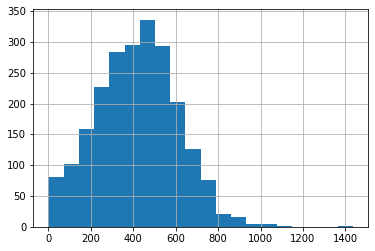

In [45]:
smart['total_duration'].hist(bins=20);

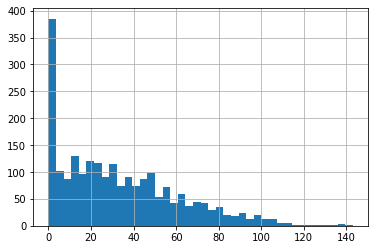

In [46]:
smart['total_messages'].hist(bins=40);

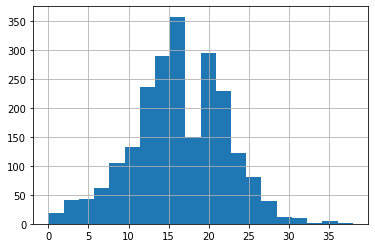

In [47]:
smart['total_traffic_gb'].hist(bins=20);

Посмотрим сколько денег компании приносит покупка дополнительных минут, сообщений и гигабайт

In [48]:
 smart['profit'].sum() - smart['rub_monthly_fee'].sum()

1649401.0

#### Вывод по тарифу *smart*

В среднем пользователи тарифа smart обычно укладываютя в доступные в тарифе минуты разгворов, однако нередки и случаи, когда люди разговаривают сверх тарифа, сообщениями люди пользуются мало, поэтому дополнительные платы за сообщения - явление редкое, а вот с интернет-трафиком обратная история. Чаще всего пользователи тарифа Смарт не укладываются в доступные 15гб интернет-трафика и вынуждены покупать дополнительный трафик за большую стоимость. Поэтому больше половина прибыли по тарифу Смарт складывается как раз из покупки дополнительных опций для данного тарифа

### Данные по тарфифу *ultra*

Условия для тарифа «Ультра»  
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей


Посмотрим как ведут себя пользователи этого тарифа, и хватает ли им предоставленных минут, сообщений и гигабайт. Ведь как мы выяснили выше, эти пользователи приносят компании больше дохода. 

In [49]:
ultra.head(5)

,user_id,city,tariff,month,total_calls,total_duration,total_messages,total_traffic_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,Краснодар,ultra,5.0,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,Краснодар,ultra,6.0,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,Краснодар,ultra,7.0,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,Краснодар,ultra,8.0,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,Краснодар,ultra,9.0,58.0,466.0,57.0,15.0,1000,30720,3000,1950,150,1,1,1950.0


In [50]:
ultra.describe()

,user_id,month,total_calls,total_duration,total_messages,total_traffic_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.000000
mean,1263.094416,8.250761,73.392893,526.623350,49.363452,19.494416,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,2070.152284
std,140.694908,2.871762,43.916853,317.606098,47.804457,9.853511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,376.187114
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
25%,1143.000000,6.000000,41.000000,284.000000,6.000000,12.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
50%,1277.000000,9.000000,74.000000,518.000000,38.000000,19.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
75%,1381.000000,11.000000,104.000000,752.000000,79.000000,27.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
max,1495.000000,12.000000,244.000000,1673.000000,224.000000,49.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,4800.000000


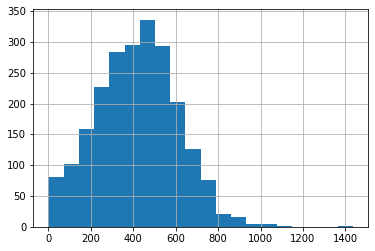

In [51]:
smart['total_duration'].hist(bins=20);

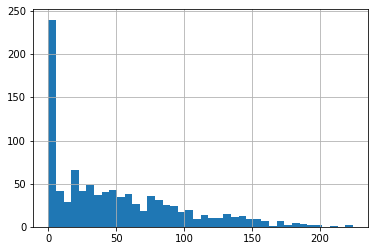

In [52]:
ultra['total_messages'].hist(bins=40);

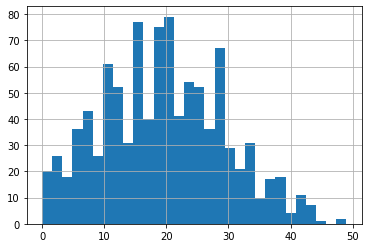

In [53]:
ultra['total_traffic_gb'].hist(bins=30);

Посмотрим сколько денег компании приносит покупка дополнительных минут, сообщений и гигабайт

In [54]:
ultra['profit'].sum() - ultra['rub_monthly_fee'].sum()

118350.0

#### Вывод по тарифу *ultra*

В тарифе Ультра картина отличается от пользователей тарифа Смарт.  
Пользователям всегда хватает минут разговора, очень редко требуются дополнительные смс-сообщения, и 30 гб интернет-трафика хватает практически всегда, дополнительные гигабайты покупают редко.  
Прибыли по дополнительным минутам, сообщениям и гигабайтам очень мала, в сравнении с тарифом Смарт

### Сравнительный анализ двух тарифов 

Посчитаем дисперсию и стандартное отклонение для ключевых распределений в тарифах

In [55]:
users_df.pivot_table(index=['tariff'],
                    values=['total_duration', 'total_messages', 'total_traffic_gb', 'profit'],
                    aggfunc=[np.var, np.std]).round(1)

var                                                   std  \
          profit total_duration total_messages total_traffic_gb profit   
tariff                                                                   
smart   669785.7        36219.3          796.8             33.0  818.4   
ultra   141516.7       100873.6         2285.3             97.1  376.2   

                                                       
       total_duration total_messages total_traffic_gb  
tariff                                                 
smart           190.3           28.2              5.7  
ultra           317.6           47.8              9.9

Посмотрим на ключевые средние значения двух тарифов - звонки, смс, гигабайты и прибыль - помесячно.

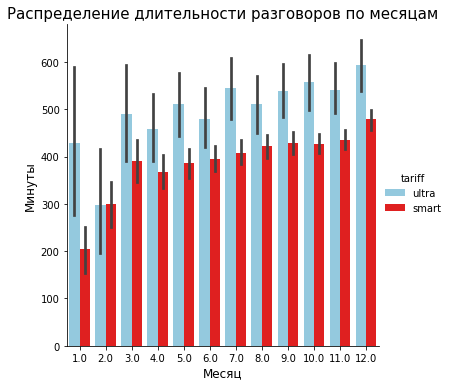

In [56]:
sns.catplot(data=users_df, kind="bar",
        x="month", y="total_duration",
        hue="tariff",
        palette=sns.color_palette(['skyblue', 'red']))
plt.title('Распределение длительности разговоров по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Минуты', fontsize=12);

plt.show()

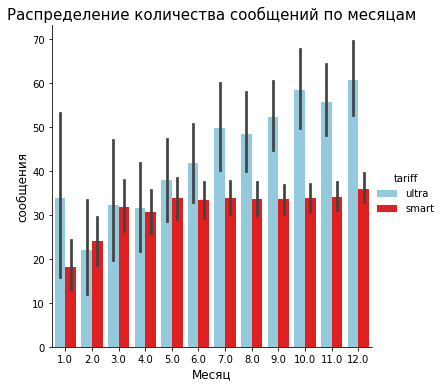

In [57]:
sns.catplot(data=users_df, kind="bar",
        x="month", y="total_messages",
        hue="tariff",
        palette=sns.color_palette(['skyblue', 'red']))
plt.title('Распределение количества сообщений по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('сообщения', fontsize=12);

plt.show()

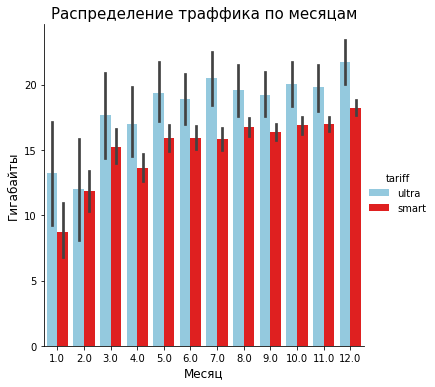

In [58]:
sns.catplot(data=users_df, kind="bar",
        x="month", y="total_traffic_gb",
        hue="tariff",
        palette=sns.color_palette(['skyblue', 'red']))
plt.title('Распределение траффика по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Гигабайты', fontsize=12);

plt.show()

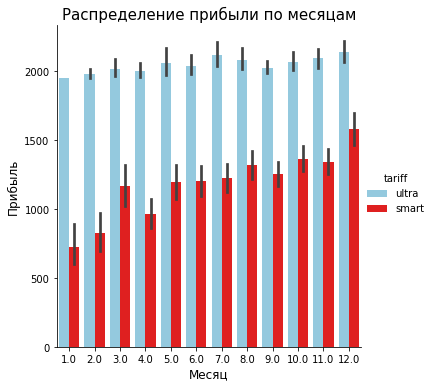

In [59]:
sns.catplot(data=users_df, kind="bar",
        x="month", y="profit",
        hue="tariff",
        palette=sns.color_palette(['skyblue', 'red']))
plt.title('Распределение прибыли по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Прибыль', fontsize=12);

plt.show()

### Промежуточный вывод по анализу двух тарифов

Изучив данные по двум тарифам, можно сделать следующие выводы:

У двух тарифов разные показатели по использованию:
- В тарифе Смарт больше покупают дополнительных минут и гигабайтов
- В тарифе Ультра пользоватям зачастую хватает включенных в тариф минут, смс, и гигабайтов
- Пользователи тарифа Ультра меньше всего пользуются связью в феврале, Смарта - в январе.
- Средняя доходность от тарифа Ультра практически весь год одниковая, а в тарифе Смарт доход растет от января к декабрю.

## Проверка гипотез

### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Проверим первую гипотезу.  
Проведем t-test, и обозначим следующие вводные данные:  
Нулевая гипотеза - средняя выручка пользователей Ультра и Смарт равна  
Альтернативная гипотеза - средняя выручка пользователей Утра и Смарт отличается   
Критический уровень статистической значимости зададим значением 0.05.  

In [60]:
alpha = 0.05 

results = st.ttest_ind(smart['profit'], ultra['profit'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Получается, что отвергая нулевую гипотезу мы можем сделать вывод, что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.  
Это также подтверждается нашими промежуточными выводами, сделанными выше, по табличным данным. 

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверим вторую гипотезу. 
Проведем t-test, и обозначим следующие вводные данные:  
Нулевая гипотеза - средняя выручка пользователей из Москвы и других регионов не отличается  
Альтернативная гипотеза - средняя выручка пользователей из Москвы и других регионов отличается     
Критический уровень статистической значимости зададим значением 0.05.  

In [61]:
### Сделаем срезы из нашего общего датафрейма user_df для возможности проверки гипотез
users_in_moscow = users_df.query('city == "Москва"')
other_users = users_df.query('city != "Москва"')

alpha = 0.05 

results = st.ttest_ind(users_in_moscow['profit'], other_users['profit'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


P-value равно 0.54, значит наша нулевая гипотеза не отвергается, что говорит о том, что средняя выручка от пользователей в Москве не отличчается от средней выручки от пользователей из всех остальных регионов страны. 

<br/>
    
<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Шаг 4. Все отлично!</b> 🏆: 


Гипотезы сформулированы верно. Выводы согласно получившемуся результату сформулирован корректно.
    

</div>

## Вывод исследования

Пользователи предпочитают тариф Смарт, поскольку у него низкая абонентская плата, но в большистве случаях доступных лимитов им не хватает и они покупают дополнительные минуты, сообщения и гигобайты.  

У тарифа Ультра гораздо меньше пользователей, выше абонентская плата, но пользователям, видимо, кажется, что такое количство минут и гигабайтов им не понадобится, поэтому предпочитают тариф с меньшей абонентской платой.  

Клиенты Мегалайна, пользующиеся тарифом Смарт приносят большую часть прибыли за счет покупки дополнительных минут и гигабайтов.  

За 2018 год доля выручки компании от покупки дополнительных минут и гигабайтов тарифа Смарт составила порядка 33%.  

Сравнительные графики по поведению пользователей в разных тарифах представлены ниже:

In [62]:
(smart['profit'].sum() - smart['rub_monthly_fee'].sum())/users_df['profit'].sum()

0.33562263618052146

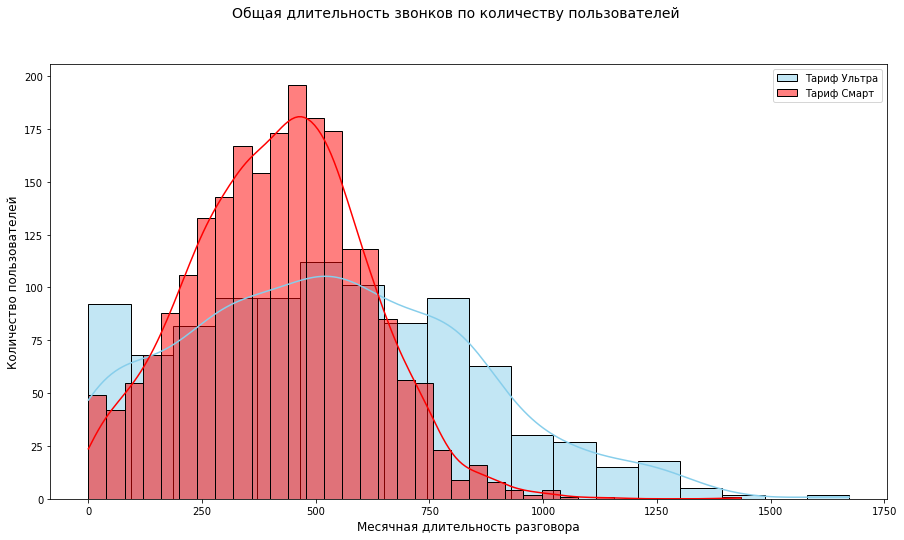

In [63]:
fig = plt.figure(figsize=(15, 8))
fig = sns.histplot(ultra.total_duration, color="skyblue", label="Тариф Ультра", kde=True)
fig = sns.histplot(smart.total_duration, color="red", label="Тариф Смарт", kde=True)

fig.figure.suptitle("Общая длительность звонков по количеству пользователей", fontsize = 14)
plt.xlabel('Месячная длительность разговора', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend()
plt.show()

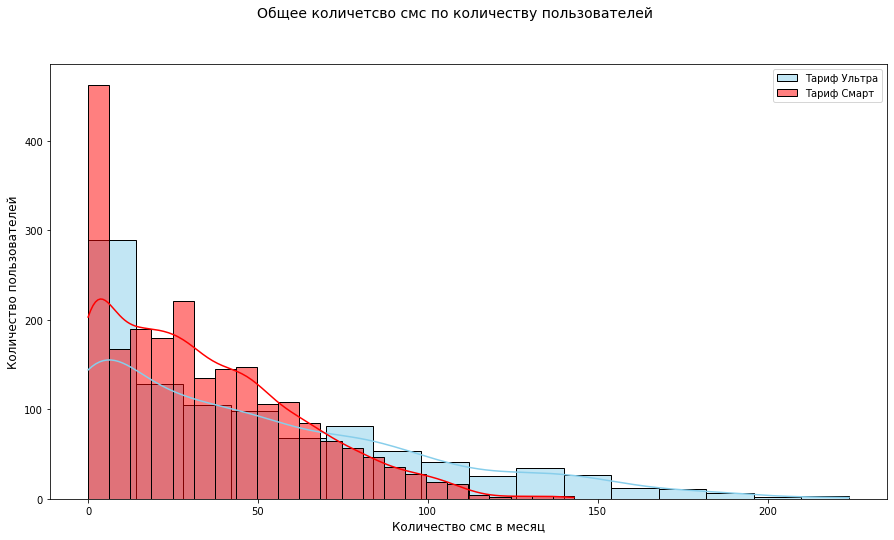

In [64]:
fig = plt.figure(figsize=(15, 8))
fig = sns.histplot(ultra.total_messages, color="skyblue", label="Тариф Ультра", kde=True)
fig = sns.histplot(smart.total_messages, color="red", label="Тариф Смарт", kde=True)

fig.figure.suptitle("Общее количетсво смс по количеству пользователей", fontsize = 14)
plt.xlabel('Количество смс в месяц', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend()
plt.show()

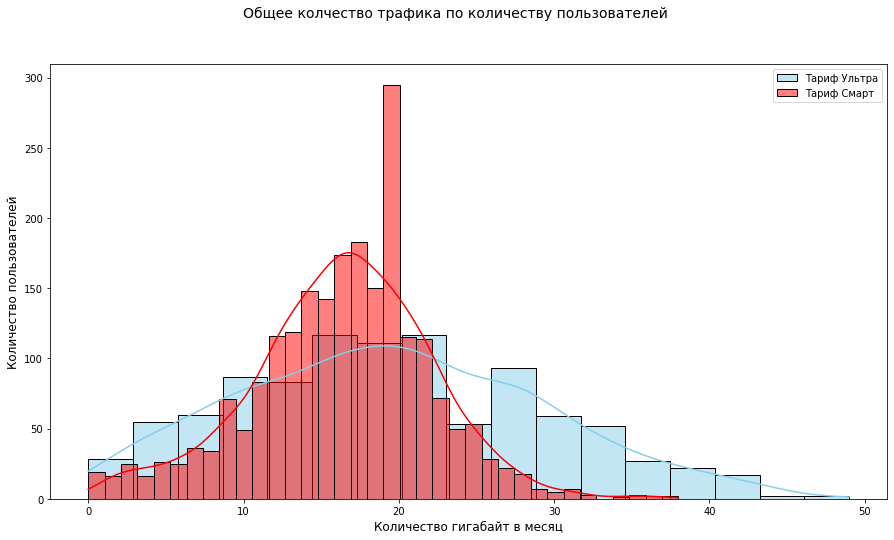

In [65]:
fig = plt.figure(figsize=(15, 8))
fig = sns.histplot(ultra.total_traffic_gb, color="skyblue", label="Тариф Ультра", kde=True)
fig = sns.histplot(smart.total_traffic_gb, color="red", label="Тариф Смарт", kde=True)

fig.figure.suptitle("Общее колчество трафика по количеству пользователей", fontsize = 14)
plt.xlabel('Количество гигабайт в месяц', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend()
plt.show()

Также мы проверили две гипотезы и делаем выводы, что средняя выручка от пользователей тарифов "Ультра" и "Смарт" различается, что также подтверждается данными в подготовке к нашему исследованию
И также мы пришли к выводу, что пользватели Мегалайна из Москвы в среднем за год приносят компании столько же денег, сколько и пользователи в остальных регионах. 

В целом, у компании избрана очень хорошая тактика по ценовой политике тарифов, из двух тарифов - один дешевле, другой дороже, пользователи предпочитают более дешевый тариф, однако потом им приходится покупать себе дополнительные опции, что приносит компании Мегалайн очень хорошие деньги.